In [124]:
%matplotlib inline
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as T
import math
import random
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
from collections import namedtuple
from itertools import count
from state_gen import getkey
from pinwheel import pinwheel, sample


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
#device = torch.device("cpu")

fname = "games/1.game.p"
target_v = pickle.load( open("dp/1.game.p.v", "rb"))
config = pickle.load( open(fname, "rb") )
g = pinwheel(config) 

In [125]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3,6,2)
        self.fc1 = nn.Linear(96, 40)
        self.head = nn.Linear(40, 4)
        
        self.conv1.weight.data.fill_(0.0)
        self.conv1.bias.data.fill_(0.0)
        self.fc1.weight.data.fill_(0.0)
        self.fc1.bias.data.fill_(0.0)
        self.head.weight.data.fill_(0.0)
        self.head.bias.data.fill_(0.0)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.head(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class BatchBin(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return self.memory

    def __len__(self):
        return len(self.memory)

In [126]:
#init screen
# channels = (spaces, position, goal)
screen = torch.zeros(3, 10, 10, dtype=torch.float32)

#init blank channel
for i in range(g.nrows):
    for j in range(g.ncols):
        if g.board[i][j] != 'x':
            screen[0,i,j] = 1.0


def get_screen():
    screen[1,:,:] = 0.0
    screen[2,:,:] = 0.0
    # agent position / goal
    i, j = g.pos[0]
    screen[1,i,j] = 1.0
    i, j = g.goals[0]
    screen[2,i,j] = 1.0
            
    # Resize, and add a batch dimension (BCHW)
    return screen.unsqueeze(0)
    #return resize(screen).unsqueeze(0).to(device)

def show_screen(state):
    val = state.cpu().squeeze(0)[:,:g.nrows,:g.ncols]
    plt.clf()
    fig = plt.figure(1)
    plt.imshow((val[0] + val[1] + val[2]/2.).numpy())
    
    #plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
    


In [127]:
BATCH_SIZE = 128 #transitions
GAMMA = 0.9
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 400 #400 actions
TARGET_UPDATE = 10

policy_net = DQN()
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.SGD(policy_net.parameters(), lr=0.01)

steps_done = 0
episode_score = []
memory = BatchBin(BATCH_SIZE)

In [128]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(4)]], dtype=torch.long)

epsilons = []
def plot_score():
    epsilons.append(EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY))
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(1,2)
    durations_t = torch.tensor(episode_score, dtype=torch.float)
    e_t = torch.tensor(epsilons, dtype=torch.float)
    ax1.plot(durations_t.numpy())
    ax2.plot(e_t.numpy())
    
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax1.plot(means.numpy())

    #plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    display.clear_output(wait=True)
    display.display(plt.gcf())


In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [146]:
out = [[] for i in range(len(g.states))]
crit = nn.MSELoss()
def train_on_dp(vd):
    for out_id, (k,state_val) in enumerate(vd.items()):
        g.init_ep(g.states[k])
        if g.isTerminal():
            continue
        state = get_screen()
        
        target = []
        
        for i in range(len(g.actions)):
            sn, r = g.move1(g.actions[i])
            target.append(vd[sn]*GAMMA+r)
            g.init_ep(g.states[k])
            
        optimizer.zero_grad()
        output = policy_net(state)
        print(output)
        print(target)
        loss = crit(output, torch.Tensor(target).unsqueeze(0))
        return loss
        out[out_id].append(loss.item())
        loss.backward()
        #for param in policy_net.parameters():
            #param.grad.data.clamp_(-1, 1)
        optimizer.step()
        return loss



In [151]:
policy_net(get_screen()).grad_fn.next_functions

((<ExpandBackward at 0x1d4dc6e5208>, 0),
 (<ReluBackward at 0x1d4dc6e5c50>, 0),
 (<TBackward at 0x1d4dc6e5ba8>, 0))

In [148]:
loss = train_on_dp(target_v)
loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0]

tensor([[0.1586, 0.1835, 0.1835, 0.1586]], grad_fn=<ThAddmmBackward>)
[0.6561000000000001, 0.7290000000000001, 0.7290000000000001, 0.6561000000000001]


In [72]:
l.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0].grad_fn

AttributeError: 'AccumulateGrad' object has no attribute 'grad_fn'

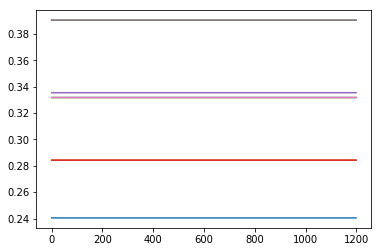

In [51]:
for i in range(1000):
    train_on_dp(target_v)

figure = plt.figure()
for row in out:
    plt.plot(row)

In [7]:
num_episodes = 10000
for i_episode in range(num_episodes):
    # Initialize the environment and state
    g.init_ep()
    reward_sum = 0
    for t in count():
        state = get_screen()
        # Select and perform an action
        action = select_action(state)
        sn, reward = g.move1([action.item()])
        reward = torch.tensor([reward], device=device, dtype=torch.float)
        reward_sum += reward

        # Observe new state
        done = g.isTerminal()
        if not done:
            next_state = get_screen()
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Perform one step of the optimization (on the target network)
        optimize_model()
        
        if done or t > 20:
            episode_score.append(t+1)
            #plot_score()
            break
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if i_episode % 250 == 0:
        print(i_episode / 10000. * 100.)
            

print('Complete')
plt.ioff()


0.0
2.5
5.0
7.5
10.0
12.5
15.0
17.5
20.0
22.5
25.0
27.500000000000004
30.0
32.5
35.0
37.5
40.0
42.5
45.0
47.5
50.0
52.5
55.00000000000001
57.49999999999999
60.0
62.5
65.0
67.5
70.0
72.5
75.0
77.5
80.0
82.5
85.0
87.5
90.0
92.5
95.0
97.5
Complete


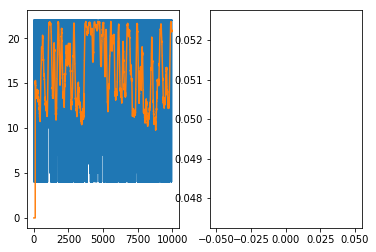

In [9]:
plot_score()

In [10]:
import time
def test_net():
    g.init_ep()
    reward_sum = 0
    for i in range(200):
        state = get_screen()
        action = select_action(state)
        sn, reward = g.move1(action)
        show_screen(state)
        time.sleep(1 / 20.)
        if g.isTerminal():
            break
            

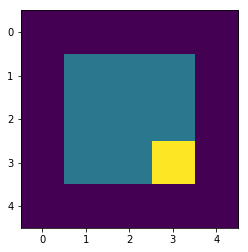

[[0. 0. 0. 0.]]
[0.9, 1.0, 1.0, 0.9]
['^', '>', 'v', '<']



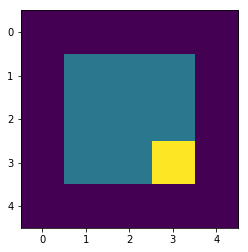

In [11]:

        
        show_screen(state)
        print(action_val.detach().numpy())
        print(expected_action_val)
        print(['^', '>', 'v', '<'])
        input()
        
train_on_dp(target_v)